In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-10-24 18:42:45.069713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:42:45.087406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:42:45.092638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:42:46.470400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

In [3]:
cmip6_train.shape

(23741, 42, 97)

#### Build the CNN Model (Keras with JAX Backend)
Now let's define a simple CNN model using Keras with JAX backend. Our model will take the coarse-resolution CMIP6 data and predict the high-resolution GMFD data.



In [4]:
import keras
from keras import layers

def build_simple_cnn(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    n = 32  # base filter count
    x = inputs

    # First block (n filters)
    for i in range(10):
        x = layers.Conv2D(n, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Second block (2n filters)
    for i in range(10):
        x = layers.Conv2D(2*n, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Third block (4n filters)
    for i in range(10):
        x = layers.Conv2D(4*n, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Final convolutional layer
    outputs = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(x)
    
    # Build model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
model = build_simple_cnn(input_shape)

#### Split the data
Train set: The first portion of the time period (e.g., 60-70% of the time series).
Validation set: The next portion of the time series (e.g., the following 15-20% of the time series).
Test set: The final portion of the time series (e.g., the last 15-20%): 

In [5]:
# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
gmfd_train_reshaped = gmfd_train[..., np.newaxis]

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]

# Split indices based on time series order
train_size = int(n_samples * 0.6)  # 60% for training
val_size = int(n_samples * 0.2)    # 20% for validation
test_size = n_samples - train_size - val_size  # Remainder for test
print(train_size, val_size, test_size)

# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]
y_train = gmfd_train_reshaped[:train_size]

X_val = cmip6_train_reshaped[train_size:train_size + val_size]
y_val = gmfd_train_reshaped[train_size:train_size + val_size]

X_test = cmip6_train_reshaped[train_size + val_size:]
y_test = gmfd_train_reshaped[train_size + val_size:]

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1           # Print messages
)

model.compile(optimizer=keras.optimizers.SGD(), loss='mean_squared_error')

# Training the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],  # Add early stopping callback
    verbose=1
)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

14244 4748 4749
Epoch 1/50
432/446 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6717

KeyboardInterrupt: 

#### Define the hyperparameter grid and perform tuning

#### Evaluate the model on validation data

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


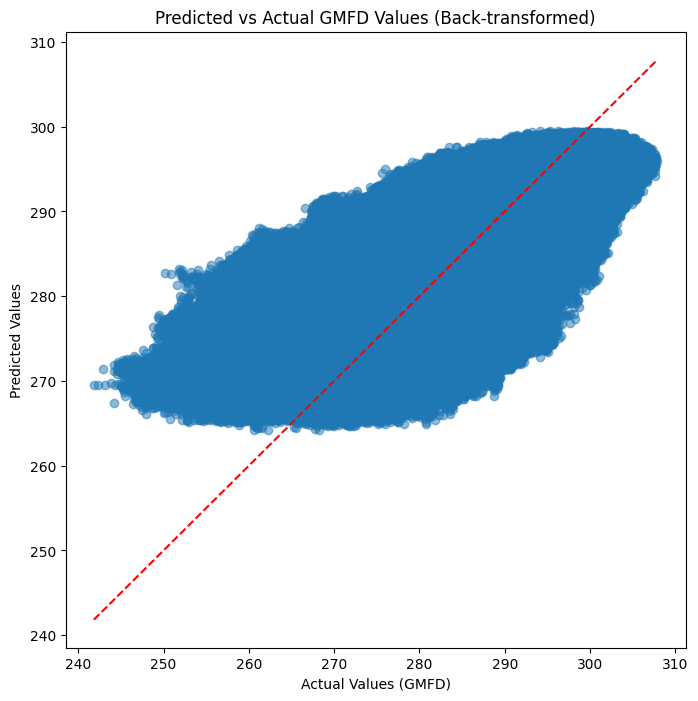

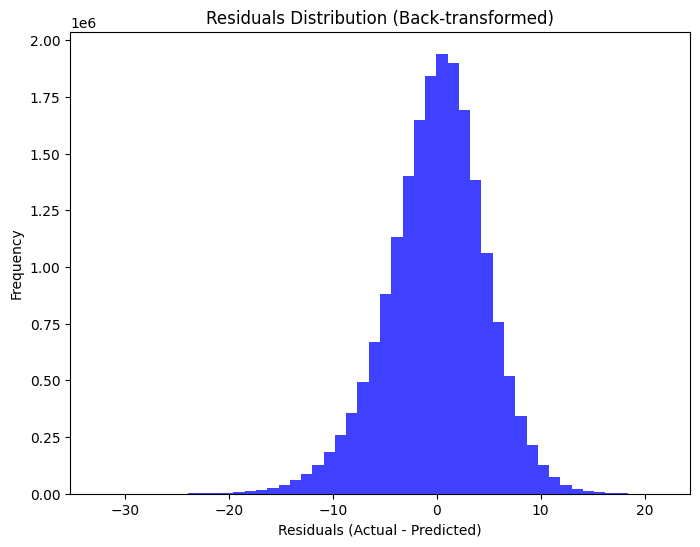

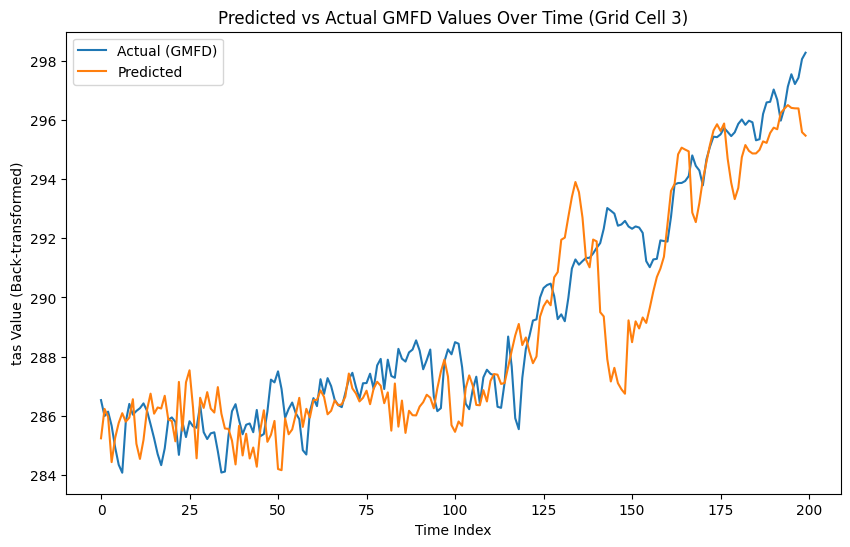

In [19]:
import numpy as np

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# # Evaluate on the denormalized test data
# val_mse, val_mae = model.evaluate(X_test, y_test, verbose=1)
# print(f"Validation MAE: {val_mae}")
# print(f"Validation MSE: {val_mse}")

# Save the best model
keras.saving.save_model(model, 'models/cnn.keras')

# Generate predictions on validation data
y_pred = model.predict(X_val)


# Back-transform the predictions for evaluation
y_val_denorm = denormalize(y_val, cmip6_high_res_mean, cmip6_high_res_std)
y_pred_denorm = denormalize(y_pred, cmip6_high_res_mean, cmip6_high_res_std)

# Plot: Predicted vs Actual Values (back-transformed)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], [y_val_denorm.min(), y_val_denorm.max()], 'r--')  # Line of perfect prediction
plt.show()

# Plot: Residuals (Actual - Predicted) after back-transform
residuals_denorm = y_val_denorm.flatten() - y_pred_denorm.flatten()
plt.figure(figsize=(8, 6))
plt.hist(residuals_denorm, bins=50, alpha=0.75, color='blue')
plt.title('Residuals Distribution (Back-transformed)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Plot: Predicted and Actual Values Over Time for a Specific Grid Cell (Back-transformed)
# Select a grid cell (e.g., the first one)
grid_cell_index = 3
plt.figure(figsize=(10, 6))
plt.plot(y_val_denorm[:200, grid_cell_index, 0].flatten(), label='Actual (GMFD)')
plt.plot(y_pred_denorm[:200, grid_cell_index, 0].flatten(), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('tas Value (Back-transformed)')
plt.title(f'Predicted vs Actual GMFD Values Over Time (Grid Cell {grid_cell_index})')
plt.legend()
plt.show()


#### Train the Best Model on All Data
Train the model on all the data (no splitting)

In [22]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
model = build_simple_cnn(input_shape)
model.compile(optimizer=keras.optimizers.SGD(), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model on all the data (no splitting)
history = model.fit(
    cmip6_train_reshaped, gmfd_train_reshaped,
    epochs=1500,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training loss
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()

Epoch 1/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - loss: 0.5417
Epoch 2/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - loss: 0.3270
Epoch 3/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 0.3206
Epoch 4/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 0.3084
Epoch 5/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.3050
Epoch 6/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2965
Epoch 7/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2886
Epoch 8/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2914
Epoch 9/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2837
Epoch 10/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2825
Epoch 11/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2785
Epoch 12/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 0.2760
Epoch 13/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2758
Epoch 14/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - loss: 0.2714
E

KeyboardInterrupt: 

343/742 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.2332

#### Apply the Model to CMIP6 Data to Downscale to GMFD Original Resolution
Now we take the coarse CMIP6 data and downscale it to the original GMFD resolution


In [23]:
# Load the model
from keras.models import load_model
#model = load_model('models/cnn.keras')

# Predict downscaled high-resolution data
predicted_high_res = model.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


#### Post-process the Predictions

In [24]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values


# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_high_res_mean, cmip6_high_res_std)

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/predicted_high_res_tas_cnn.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.
